# Experiment with dataset 1_kaggle_jpaladin

Autistic and non-autistic children faces

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
from os import path, listdir
import torch
import torchvision
from typing import Tuple, Dict

In [2]:
from torch import nn


def create_effnetb0_model(num_classes:int=7, 
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.
    Args:
        num_classes (int, optional): number of classes in the classifier head. 
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.
    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model. 
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b0(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1280, out_features=num_classes),
    )
    
    return model, transforms

In [3]:
# Setup class names
class_names = ["Happy", "Disgusted", "Suprised","Angry","Neutral","Sad","Fearful"]

# Create EffNetB2 model
effnetb0, effnetb0_transforms = create_effnetb0_model(
    num_classes=7, # len(class_names) would also work
)

# Load saved weights


# Load saved weights
effnetb0.load_state_dict(
    torch.load(
        f="models/efficientnet_b0.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to C:\Users\foxel/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-3dd342df.pth
100.0%


<All keys matched successfully>

In [4]:
def predict(img) -> Dict:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    
    # Transform the target image and add a batch dimension
    img = effnetb0_transforms(img).unsqueeze(0)
    
    # Put model into evaluation mode and turn on inference mode
    effnetb0.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb0(img), dim=1)
    
    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    
    return pred_labels_and_probs

In [42]:
datadir = r"D:\data\asd\1_kaggle_jpaladin\images"

image_list = ["autistic/" + example for example in listdir(path.join(datadir, "autistic"))]

In [15]:
from PIL import Image

In [27]:
def show_results(image, prob):
    argmax_key = max(prob, key=prob.get)
    argmax_val = '{0:.2f}'.format(prob[argmax_key] * 100)
    print(f'Prediction: {argmax_key} with probability { argmax_val }% ')
    display(image)

Prediction: Happy with probability 45.48% 


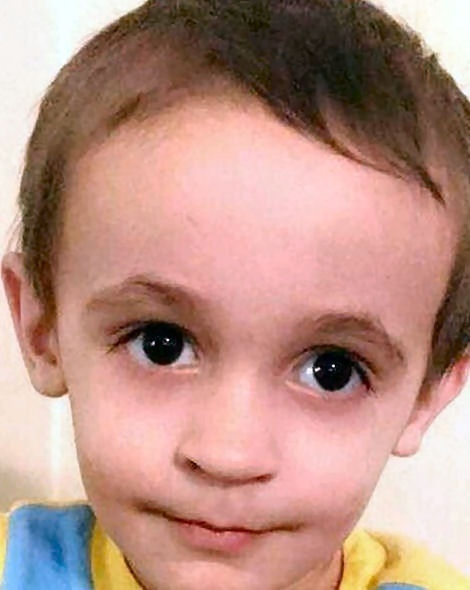

In [44]:
image = Image.open(path.join(datadir, image_list[0]))
probs = predict(image)
show_results(image, probs)

In [39]:
def assign_label(image, prob, counts, prob_level):
    argmax_key = max(prob, key=prob.get)
    argmax_val = prob[argmax_key] 
    counts[argmax_key] = counts[argmax_key] + 1
    prob_level[argmax_key] = prob_level[argmax_key] + argmax_val
    return counts, prob_level

In [45]:
counts = dict.fromkeys(class_names,0)
prob_level = dict.fromkeys(class_names,0)
for im in image_list:
    image = Image.open(path.join(datadir, im))
    probs = predict(image)
    counts, prob_level = assign_label(image, probs, counts, prob_level)


In [62]:
prob_level.update(zip(prob_level.keys(), [ y  / x  * 100 for (x,y) in zip(counts.values(), prob_level.values())]))

In [63]:
print(counts)

{'Happy': 827, 'Disgusted': 4, 'Suprised': 82, 'Angry': 71, 'Neutral': 434, 'Sad': 3, 'Fearful': 42}


In [64]:
print(prob_level)

{'Happy': 71.758455585828, 'Disgusted': 58.72436314821243, 'Suprised': 54.8237734633248, 'Angry': 52.15450789726955, 'Neutral': 60.6723445351772, 'Sad': 34.99150673548381, 'Fearful': 47.08987481537319}
